# Twitter Data Analysis

## Setup

In [1]:
import sys 
sys.path.append("../")

In [70]:
from itertools import chain 
from collections import Counter 

In [43]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

import pickle as pkl

In [71]:
from lib.preprocessing.tweets import clean_tweet 
from lib.preprocessing.text import (
    tokenize, 
    remove_punctuation, 
    remove_stopwords, 
    stem
)

## Data

We load the labelled dataset obtained from the [tw-classification](notebooks/tw-classification.ipynb) notebook. The data is only made up of tweets that have been classified as related to prices. The labelled dataset is then merged to the original dataset which contains tweets' features (text, number of retweets/likes/comments, timestamp, etc.).

In [25]:
data_path = "../backup/data/df_cleaned.csv"
df = pd.read_csv(data_path)

label_path = "../backup/data/labels.csv"
labels = pd.read_csv(label_path)

In [26]:
df = pd.concat([df, labels], axis=1)
df

,timestamp,text,emojis,retweets,likes,comments,lexical_field,text_emojis,predicted,hand_labelled
0,2020-01-01,le tout vendu à des prix \n«défiant toute conc...,NaN,NaN,NaN,NaN,cheap,le tout vendu à des prix \n«défiant toute conc...,0,0
1,2020-01-01,Pour ceux qui veulent allier l'utile à l'agréa...,🛑 🛑,NaN,NaN,NaN,cheap,Pour ceux qui veulent allier l'utile à l'agréa...,0,0
2,2020-01-02,"Nouvelle perspective: BARAKA BUSINESS SARL, ne...",NaN,3.0,NaN,NaN,cheap,"Nouvelle perspective: BARAKA BUSINESS SARL, ne...",0,1
3,2020-01-02,J'ai du mal à savoir si #Cirelli a reçu la Leg...,NaN,3.0,1.0,NaN,cheap,J'ai du mal à savoir si #Cirelli a reçu la Leg...,0,0
4,2020-01-06,Un iPhone pas cher ? C’est maintenant possible...,⭐ 😉,284.0,69.0,36.0,cheap,Un iPhone pas cher ? C’est maintenant possible...,0,0
...,...,...,...,...,...,...,...,...,...,...
92956,2022-12-30,Mercredi 16h : on appelle pour visiter.\nJeudi...,🤯 🤯 🤯,31.0,NaN,4.0,prices,Mercredi 16h : on appelle pour visiter.\nJeudi...,0,0
92957,2022-12-30,"Avec la #Justinflation, les Canadiens ont vu f...",NaN,298.0,47.0,68.0,prices,"Avec la #Justinflation, les Canadiens ont vu f...",1,0
92958,2022-12-30,La mairie de Biarritz a cessé de payer l’élec...,💡,58.0,11.0,3.0,prices,La mairie de Biarritz a cessé de payer l’élec...,0,0
92959,2022-12-30,L'architecte japonais Arata Isozaki est mort à...,NaN,20.0,8.0,4.0,prices,L'architecte japonais Arata Isozaki est mort à...,0,0


In [29]:
# convert date to datetime object 

df["timestamp"] = pd.to_datetime(df["timestamp"])

We then create the target variable which indicates whether the tweet is related to prices/inflation. To that end we combine the 1,000 labels added manual and the remanining obtained with the classifier implemented [here](notebooks/tw-classification.ipynb).

In [7]:
def create_target_variable(predicted: int, hand_labelled: int) -> int: 
    """Description. Combine predicted and manual labels to create target variable."""

    if float(predicted) not in (0., 1.) or float(hand_labelled) not in (0., 1.): 
        raise ValueError("predicted and hand_labelled must be equal to 0 or 1.")

    label = predicted + hand_labelled

    if label == 2: 
        label = 1 
    elif predicted == 1: 
        label = 0 
    elif hand_labelled == 1: 
        label = 1 
    return label  

import pytest 
def test_create_label_variable(): 
    assert create_target_variable(predicted=1, hand_labelled=1) == 1
    assert create_target_variable(predicted=0, hand_labelled=1) == 1 
    assert create_target_variable(predicted=1, hand_labelled=0) == 0 
    assert create_target_variable(predicted=0, hand_labelled=0) == 0 

    with pytest.raises(ValueError):
        create_target_variable(predicted=-1, hand_labelled=0) 
        create_target_variable(predicted=1, hand_labelled=10)

test_create_label_variable()

In [30]:
df.loc[:, "is_about_price"] = df.apply(
    lambda x: create_target_variable(x.predicted, x.hand_labelled), 
    axis=1
)

In [31]:
df = df.drop(labels=["predicted", "hand_labelled"], axis=1)

In [32]:
# remove duplicated tweets 

df = df.drop_duplicates(subset=["text"]) 

In [33]:
tweets = df["text"].tolist()
n_tweets = len(tweets)

print(f"{n_tweets} unique tweets in the dataset.")

92175 unique tweets in the dataset.


## Text preprocessing

1. Remove tweet attributes (mentions, links, etc.)

In [35]:
tweets_cleaned = [clean_tweet(tweet) for tweet in tweets]

In [36]:
ix = np.random.randint(low=0, high=n_tweets)

print(f"Before cleaning:\n{tweets[ix]}")
print(f"\n\nAfter cleaning:\n{tweets_cleaned[ix]}")

Before cleaning:
La france est bloquée.  Les fonctionnaires sont hors de portée de toute conséquence économique. Ils tiennent le pouvoir. En +, ceux qui ne payent pas d'impôts veulent que les autres en payent encore plus. Fin statut fonctionnaire +15% impôt tout le monde
4
7
21


After cleaning:
La france est bloquée.  Les fonctionnaires sont hors de portée de toute conséquence économique. Ils tiennent le pouvoir. En +, ceux qui ne payent pas d'impôts veulent que les autres en payent encore plus. Fin statut fonctionnaire +15% impôt tout le monde


2. Tokenization

In [37]:
tweets_tokenized = [tokenize(tweet) for tweet in tweets_cleaned]

In [38]:
print(f"Before cleaning & tokenization:\n{tweets[ix]}")
print(f"\n\nAfter cleaning & tokenization:\n{tweets_tokenized[ix]}")

Before cleaning & tokenization:
La france est bloquée.  Les fonctionnaires sont hors de portée de toute conséquence économique. Ils tiennent le pouvoir. En +, ceux qui ne payent pas d'impôts veulent que les autres en payent encore plus. Fin statut fonctionnaire +15% impôt tout le monde
4
7
21


After cleaning & tokenization:
['la', 'france', 'est', 'bloquée', '.', 'les', 'fonctionnaires', 'sont', 'hors', 'de', 'portée', 'de', 'toute', 'conséquence', 'économique', '.', 'ils', 'tiennent', 'le', 'pouvoir', '.', 'en', '+,', 'ceux', 'qui', 'ne', 'payent', 'pas', 'd', "'", 'impôts', 'veulent', 'que', 'les', 'autres', 'en', 'payent', 'encore', 'plus', '.', 'fin', 'statut', 'fonctionnaire', '+', '15', '%', 'impôt', 'tout', 'le', 'monde']


3. Remove punctuation and stopwords

In [39]:
tweets_no_punc = [remove_punctuation(tokens) for tokens in tweets_tokenized]

In [72]:
tweets_no_stopwords = [remove_stopwords(tokens) for tokens in tweets_no_punc]

In [73]:
print(f"Before full cleaning:\n{tweets[ix]}")
print(f"\n\nAfter full cleaning:\n{tweets_no_stopwords[ix]}")

Before full cleaning:
La france est bloquée.  Les fonctionnaires sont hors de portée de toute conséquence économique. Ils tiennent le pouvoir. En +, ceux qui ne payent pas d'impôts veulent que les autres en payent encore plus. Fin statut fonctionnaire +15% impôt tout le monde
4
7
21


After full cleaning:
['france', 'bloquée', 'fonctionnaires', 'portée', 'conséquence', 'économique', 'tiennent', 'pouvoir', 'payent', 'pas', 'impôts', 'veulent', 'payent', 'fin', 'statut', 'fonctionnaire', '15', 'impôt', 'monde']


4. Update dataset 

- Add preprocessed tweets
- Add number of tokens per tweet

In [79]:
df.loc[:, "tokens"] = np.array(tweets_no_stopwords, dtype=object) 
df.loc[:, "n_tokens"] = df.loc[:, "tokens"].apply(len)

## Data visualisation

### Tweet statistics

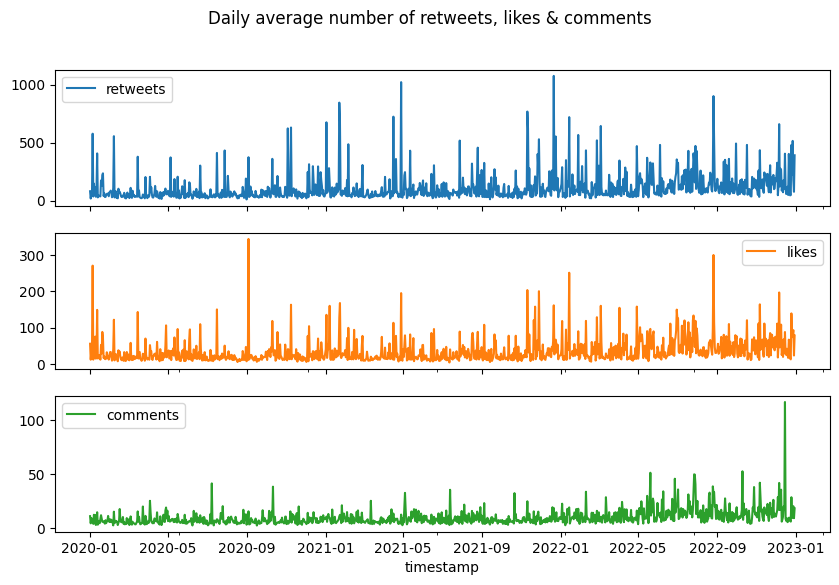

In [75]:
by = [df.timestamp.dt.date]
num_cols = ["retweets", "likes", "comments"]

df.\
    groupby(by)[num_cols].\
    mean().\
    plot(subplots=True, figsize=(10, 6), title="Daily average number of retweets, likes & comments"); 

### Text visualisation

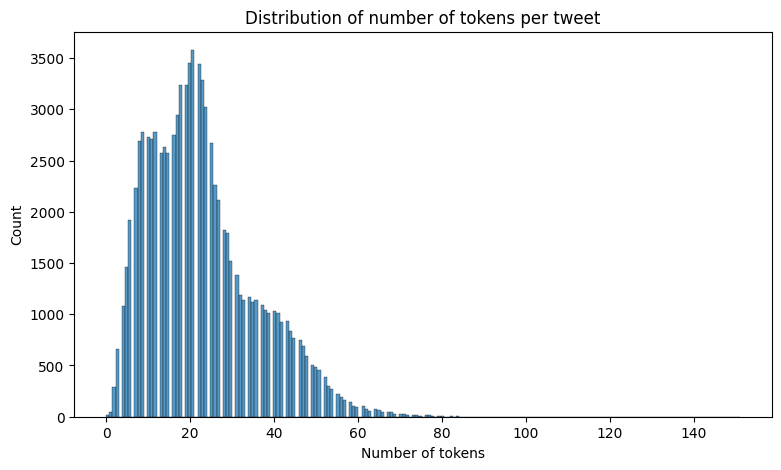

In [80]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.histplot(data=df, x="n_tokens", ax=ax)
ax.set_xlabel("Number of tokens")
ax.set_title("Distribution of number of tokens per tweet");  

In [81]:
tokens = list(chain(*df.tokens.values))
token_counts = Counter(tokens)

In [82]:
token_counts.most_common(10)

[('’', 90275),
 ('inflation', 43646),
 ('prix', 24870),
 ('pas', 23742),
 ('«', 10849),
 ('»', 10317),
 ('1', 9477),
 ('2', 8385),
 ('taux', 7918),
 ('payer', 6753)]